# Boundless DAS: Feature-Level Subspace Tracing

In this notebook, we use **Boundless DAS** (mask intervention with `tie_masks=False`) to learn which feature dimensions within each model component are important for realizing causal variables.

Unlike DBM with `tie_masks=True` which selects/deselects entire units, Boundless DAS learns a mask over individual features within each unit, providing a more fine-grained view.

We will trace across three component types:
1. **Residual Stream**: Per-layer analysis across all layers
2. **Attention Heads**: All heads across all layers in a single model
3. **MLPs**: All MLPs across all layers in a single model

We run this analysis for the **answer** variable using `different_symbol` counterfactuals.

In [1]:
%load_ext autoreload
%autoreload 2

# Core imports
from causalab.tasks.MCQA.causal_models import positional_causal_model
from causalab.tasks.MCQA.counterfactuals import different_symbol
from causalab.tasks.MCQA.token_positions import create_token_positions

# Neural framework imports
from causalab.neural.pipeline import LMPipeline

# Causal and filtering imports
from causalab.causal.causal_utils import save_counterfactual_examples
from causalab.experiments.filter import filter_dataset

# Interchange target builders
from causalab.experiments.interchange_targets import (
    build_residual_stream_targets,
    build_attention_head_targets,
    build_mlp_targets,
)

# Boundless DAS training script
from causalab.experiments.jobs.boundless_DAS_feature_mask_grid import (
    train_boundless_DAS,
)

# Standard imports
import torch
import os

# Setup
causal_model = positional_causal_model

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "meta-llama/Llama-3.2-1B-Instruct"
pipeline = LMPipeline(
    model_name,
    max_new_tokens=1,
    device=device,
    dtype=torch.bfloat16 if device == "cuda" else torch.float32,
    max_length=32,
)
pipeline.tokenizer.padding_side = "left"


def checker(neural_output: dict[str, str], causal_output: str) -> bool:
    return (
        causal_output in neural_output["string"]
        or neural_output["string"] in causal_output
    )


print(f"Model: {model_name}")
print(f"Device: {device}")
print(f"Layers: {pipeline.model.config.num_hidden_layers}")
print(f"Heads per layer: {pipeline.model.config.num_attention_heads}")
print(f"Hidden size: {pipeline.model.config.hidden_size}")

Model: meta-llama/Llama-3.2-1B-Instruct
Device: cuda
Layers: 16
Heads per layer: 32
Hidden size: 2048


## Generate and Filter Datasets

We generate `different_symbol` counterfactual datasets for localizing the **answer** variable.

In [2]:
size = 128

# Generate and filter training dataset
print("Generating training dataset...")
train_dataset = [different_symbol() for _ in range(size)]

print("Filtering training dataset...")
filtered_train_dataset = filter_dataset(
    dataset=train_dataset,
    pipeline=pipeline,
    causal_model=causal_model,
    metric=checker,
    batch_size=128,
)

# Generate and filter test dataset
print("\nGenerating test dataset...")
test_dataset = [different_symbol() for _ in range(size)]

print("Filtering test dataset...")
filtered_test_dataset = filter_dataset(
    dataset=test_dataset,
    pipeline=pipeline,
    causal_model=causal_model,
    metric=checker,
    batch_size=128,
)

# Save datasets to disk
train_dataset_path = "./temp_train_datasets/different_symbol/filtered_dataset"
test_dataset_path = "./temp_test_datasets/different_symbol/filtered_dataset"

os.makedirs(train_dataset_path, exist_ok=True)
os.makedirs(test_dataset_path, exist_ok=True)

save_counterfactual_examples(filtered_train_dataset, train_dataset_path)
save_counterfactual_examples(filtered_test_dataset, test_dataset_path)

print(f"\nTrain dataset: {len(filtered_train_dataset)} examples (from {size})")
print(f"Test dataset: {len(filtered_test_dataset)} examples (from {size})")
print(f"Saved to: {train_dataset_path}")

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Generating training dataset...
Filtering training dataset...

Generating test dataset...
Filtering test dataset...


Saving the dataset (0/1 shards):   0%|          | 0/112 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/111 [00:00<?, ? examples/s]


Saved train dataset: ./temp_train_datasets/different_symbol/filtered_dataset
Saved test dataset: ./temp_test_datasets/different_symbol/filtered_dataset


In [3]:
# Create token positions for residual stream and MLP interventions
token_positions_dict = create_token_positions(pipeline)

# Select which token positions to use
ordered_position_names = [
    "correct_symbol",
    "correct_symbol_period",
    "symbol0",
    "symbol0_period",
    "symbol1",
    "symbol1_period",
    "last_token",
]

token_positions = [token_positions_dict[name] for name in ordered_position_names]

print(f"Using {len(token_positions)} token positions:")
for name in ordered_position_names:
    print(f"  - {name}")

Using 7 token positions:
  - correct_symbol
  - correct_symbol_period
  - symbol0
  - symbol0_period
  - symbol1
  - symbol1_period
  - last_token


## Training Configuration

Configure Boundless DAS training parameters. Key settings:
- `intervention_type="mask"`: Use mask-based intervention
- `tie_masks=False`: Learn per-feature masks (Boundless DAS)
- `n_features`: Number of learned subspace dimensions

In [4]:
from causalab.experiments.configs.train_config import PartialExperimentConfig

# Training configuration
# Note: The train_boundless_DAS function will set intervention_type="mask"
# and tie_masks=False automatically

config: PartialExperimentConfig = {
    "train_batch_size": 128,
    "evaluation_batch_size": 64,
    "training_epoch": 6,
    "init_lr": 0.001,
    "DAS": {
        "n_features": 2048,  # Number of features for SubspaceFeaturizer, matches the model's residual stream dimension
    },
    "masking": {
        "regularization_coefficient": 0.0001,
        "temperature_annealing_fraction": 0.5,
        "temperature_schedule": (1.0, 0.001),
    },
}

print("Training Configuration:")
print(f"  train_batch_size: {config['train_batch_size']}")
print(f"  training_epoch: {config['training_epoch']}")
print(f"  init_lr: {config['init_lr']}")
print(f"  n_features: {config['DAS']['n_features']}")
print(
    f"  regularization_coefficient: {config['masking']['regularization_coefficient']}"
)

Training Configuration:
  train_batch_size: 128
  training_epoch: 6
  init_lr: 0.001
  n_features: 2048
  regularization_coefficient: 0.0001


## 1. Residual Stream: Per-Layer Analysis

Train Boundless DAS on the residual stream, one model per layer. This reveals how feature representations evolve across layers.

Built 16 residual stream targets (one per layer)


/mnt/polished-lake/home/atticus/github/causalab-internal-boundlessDAS/causalab/experiments/visualizations/utils.py:294: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


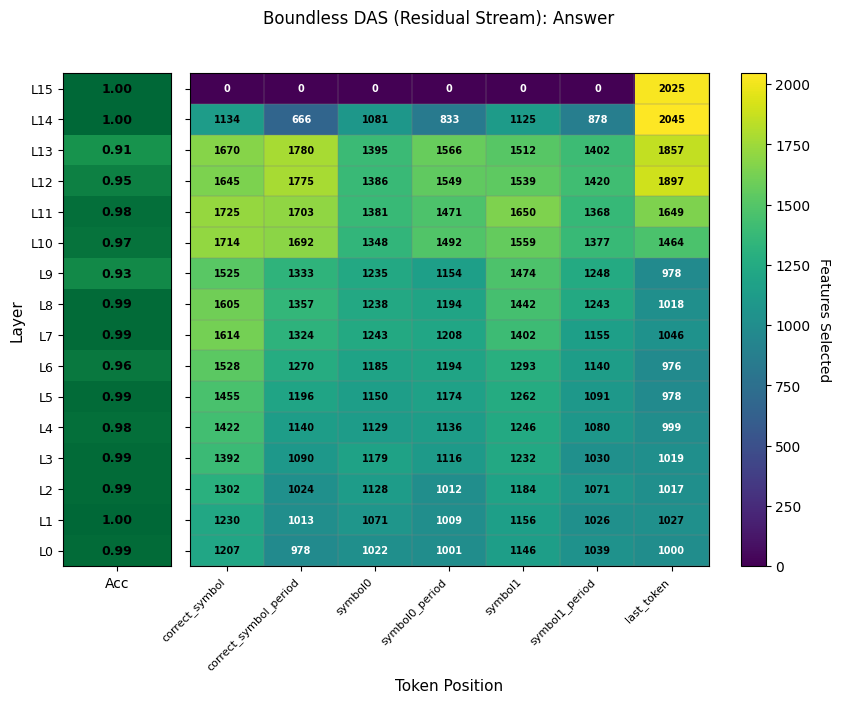


Residual Stream Results:
  Best layer: 1
  Best test score: 1.000
  Average test score: 0.977


In [5]:
# Build per-layer residual stream targets
layers = list(range(pipeline.model.config.num_hidden_layers))

residual_targets = build_residual_stream_targets(
    pipeline=pipeline,
    layers=layers,
    token_positions=token_positions,
    mode="one_target_per_layer",
)

# Convert {(layer,): target} to {layer: target} format
residual_targets_by_layer = {key[0]: target for key, target in residual_targets.items()}

print(f"Built {len(residual_targets_by_layer)} residual stream targets (one per layer)")

# Train Boundless DAS
residual_result = train_boundless_DAS(
    causal_model=causal_model,
    interchange_target=residual_targets_by_layer,
    train_dataset_path=train_dataset_path,
    test_dataset_path=test_dataset_path,
    pipeline=pipeline,
    target_variable_group=("answer",),
    output_dir="./boundless_DAS_outputs/residual_stream",
    metric=checker,
    config=config,
)

print(f"\nResidual Stream Results:")
print(f"  Best layer: {residual_result['metadata']['best_layer']}")
print(f"  Best test score: {residual_result['metadata']['best_test_score']:.3f}")
print(f"  Average test score: {residual_result['metadata']['avg_test_score']:.3f}")

## 2. Attention Heads: All Heads in Single Model

Train Boundless DAS on all attention heads across all layers in a single model. This identifies which feature dimensions within each head are important.

Built attention head target with 512 units
  Layers: 16
  Heads per layer: 32


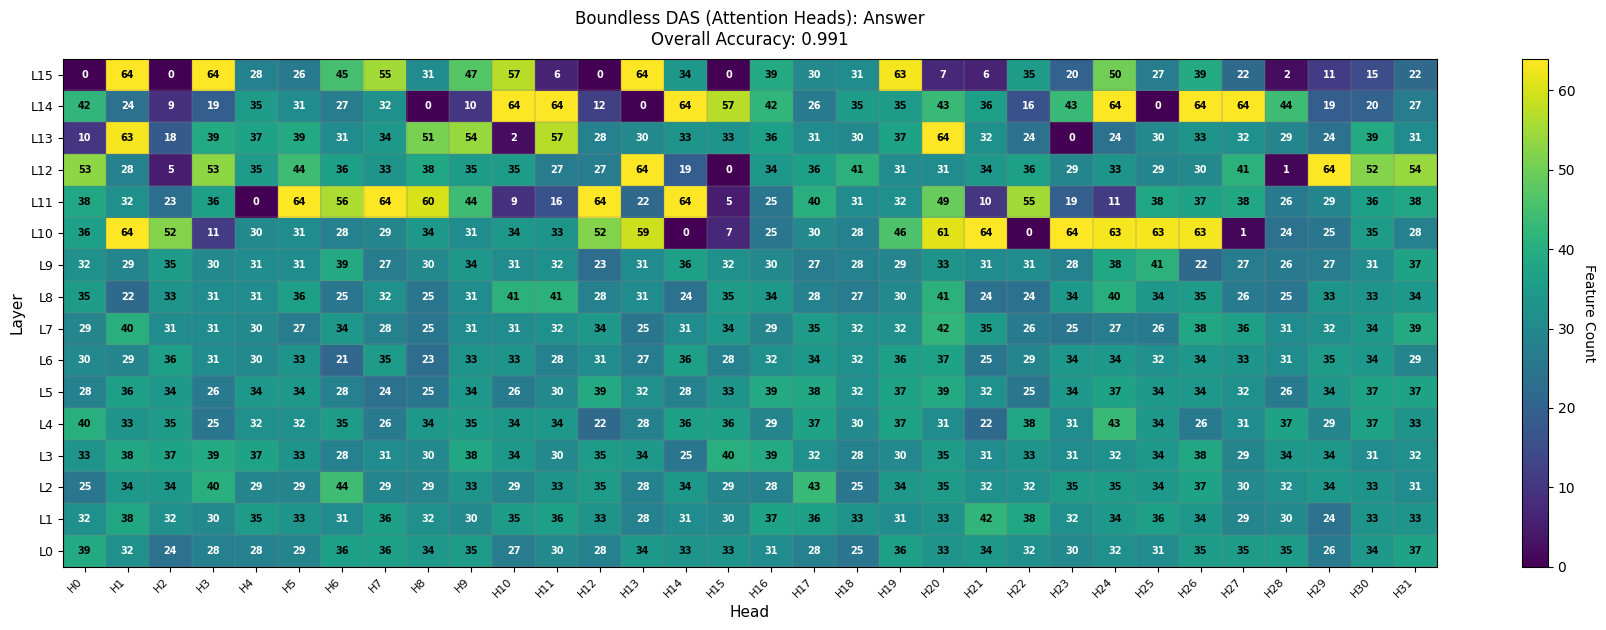


Attention Heads Results:
  Train score: 0.991
  Test score: 0.991


In [7]:
# Build attention head target (all heads in one target)
heads = list(range(pipeline.model.config.num_attention_heads))

# Use last_token position for attention heads
last_token_position = token_positions_dict["last_token"]

attention_targets = build_attention_head_targets(
    pipeline=pipeline,
    layers=layers,
    heads=heads,
    token_position=last_token_position,
    mode="one_target_all_units",
)

# Extract the single target
attention_target = attention_targets[("all",)]

print(f"Built attention head target with {len(attention_target.flatten())} units")
print(f"  Layers: {len(layers)}")
print(f"  Heads per layer: {len(heads)}")

# Create config with n_features matching head dimension (hidden_size / num_heads = 2048 / 32)
attention_config: PartialExperimentConfig = {
    **config,
    "DAS": {"n_features": 64},
}

# Train Boundless DAS
attention_result = train_boundless_DAS(
    causal_model=causal_model,
    interchange_target=attention_target,
    train_dataset_path=train_dataset_path,
    test_dataset_path=test_dataset_path,
    pipeline=pipeline,
    target_variable_group=("answer",),
    output_dir="./boundless_DAS_outputs/attention_heads",
    metric=checker,
    config=attention_config,
)

print(f"\nAttention Heads Results:")
print(f"  Train score: {attention_result['train_score']:.3f}")
print(f"  Test score: {attention_result['test_score']:.3f}")

## 3. MLPs: All MLPs in Single Model

Train Boundless DAS on all MLPs across all layers in a single model.

Built MLP target with 112 units
  Layers: 16
  Token positions: 7


/mnt/polished-lake/home/atticus/github/causalab-internal-boundlessDAS/causalab/experiments/visualizations/utils.py:294: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


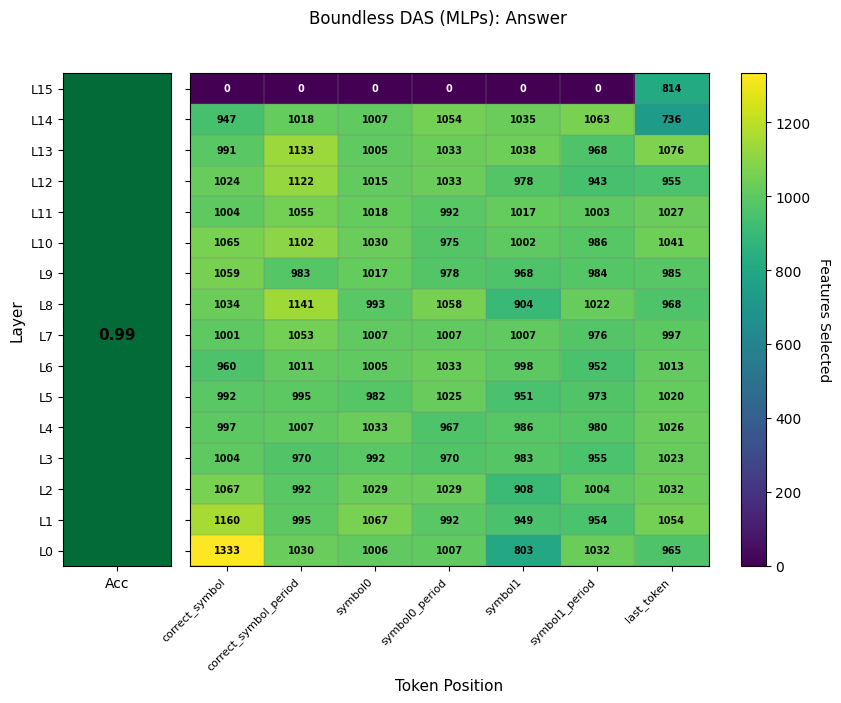


MLP Results:
  Train score: 1.000
  Test score: 0.991


In [9]:
# Build MLP target (all MLPs in one target)
mlp_targets = build_mlp_targets(
    pipeline=pipeline,
    layers=layers,
    token_positions=token_positions,
    mode="one_target_all_units",
)

# Extract the single target
mlp_target = mlp_targets[("all",)]

print(f"Built MLP target with {len(mlp_target.flatten())} units")
print(f"  Layers: {len(layers)}")
print(f"  Token positions: {len(token_positions)}")

# Create config with n_features matching the model's residual stream dimension
mlp_config: PartialExperimentConfig = {
    **config,
    "DAS": {"n_features": 2048},
}

# Train Boundless DAS
mlp_result = train_boundless_DAS(
    causal_model=causal_model,
    interchange_target=mlp_target,
    train_dataset_path=train_dataset_path,
    test_dataset_path=test_dataset_path,
    pipeline=pipeline,
    target_variable_group=("answer",),
    output_dir="./boundless_DAS_outputs/mlp",
    metric=checker,
    config=mlp_config,
)

print(f"\nMLP Results:")
print(f"  Train score: {mlp_result['train_score']:.3f}")
print(f"  Test score: {mlp_result['test_score']:.3f}")

## Results Comparison

Compare test scores across all three component types.

In [11]:
print("=" * 60)
print("BOUNDLESS DAS RESULTS: Answer Variable")
print("=" * 60)

print("\nResidual Stream (per-layer):")
print(f"  Best layer: {residual_result['metadata']['best_layer']}")
print(f"  Best test score: {residual_result['metadata']['best_test_score']:.3f}")
print(f"  Average test score: {residual_result['metadata']['avg_test_score']:.3f}")

print("\nAttention Heads (all heads):")
print(f"  Test score: {attention_result['test_score']:.3f}")

print("\nMLPs (all MLPs):")
print(f"  Test score: {mlp_result['test_score']:.3f}")

print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)
print(f"\nBest component for localizing 'answer':")
scores = {
    f"Residual Stream (layer {residual_result['metadata']['best_layer']})": residual_result[
        "metadata"
    ]["best_test_score"],
    "Attention Heads": attention_result["test_score"],
    "MLPs": mlp_result["test_score"],
}
best_component = max(scores, key=lambda k: scores[k])
print(f"  {best_component}: {scores[best_component]:.3f}")

BOUNDLESS DAS RESULTS: Answer Variable

Residual Stream (per-layer):
  Best layer: 1
  Best test score: 1.000
  Average test score: 0.977

Attention Heads (all heads):
  Test score: 0.991

MLPs (all MLPs):
  Test score: 0.991

SUMMARY

Best component for localizing 'answer':
  Residual Stream (layer 1): 1.000


## Takeaways

This notebook demonstrated **Boundless DAS** (`tie_masks=False`), which learns per-feature masks to identify which dimensions within each model component encode causal variables.

**Key observations:**

1. **Per-layer residual stream analysis**: Shows how representations evolve across layers, with early layers potentially capturing different aspects than later layers.

2. **Attention heads**: The feature count heatmap reveals which heads contribute most to encoding the answer variable, and how many dimensions within each head are important.

3. **MLPs**: Similarly shows which MLP layers and token positions encode the causal variable.

**Boundless DAS vs DBM:**
- **DBM (`tie_masks=True`)**: Binary selection - entire units are selected or not
- **Boundless DAS (`tie_masks=False`)**: Feature-level selection - learns which dimensions within each unit matter

Boundless DAS provides a more fine-grained view but requires more parameters to learn.